# Inference

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import time
import json
import copy

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras  
#setup_gpu(gpu)  #NOTICE: enable when using paperspace server!!

Using TensorFlow backend.


In [2]:
file_location = 'list_of_img_in_val_set4.csv'
place_to_store_results = 'Evaluations/'
path_img_folder = '../../../03 Data/Simple Dataset/'
accept_BB_threshold = 0.7

def convert_rect_to_point(rect):
    x = rect[0]
    y = rect[1]
    w = rect[2]
    h = rect[3]
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    
    return (x1, y1, x2, y2)

def read_annotations_from_json(img_name):
    with open(path_img_folder + img_name.strip('.png') + '.json') as json_file:
        data = json.load(json_file)
        shapes_list = data['shapes']
        annotation_list = []
        for annotation in shapes_list: 
            rect = cv2.boundingRect(np.float32(annotation['points']))
            annotation_list.append(convert_rect_to_point(rect))
    return annotation_list; 


def max_val(val1, val2):
    if val1 > val2:
        return val1
    else:
        return val2
    
def min_val(val1, val2):
    if val1 > val2:
        return val2
    else:
        return val1
    
    
def filter_bounding_boxes(bounding_boxes, scores):
    list_of_BB = []
    for box, score in zip(bounding_boxes, scores):
        if score < accept_BB_threshold: 
            break
        list_of_BB.append(box)
    return list_of_BB


def area(BB):
    width = abs(BB[0] - BB[2])
    height = abs(BB[1] - BB[3])
    return height * width

def intersection(BB1, BB2):
    # find coordiantes of intersection rectangle 
    (x1, y1, x2, y2) = BB1
    (x3, y3, x4, y4) = BB2
    if x1 > x4 or x3 > x2 or y3 > y2 or y1 > y4:
        return 0
    x5 = max_val(x1, x3);
    y5 = max_val(y1, y3);
    x6 = min_val(x2, x4);
    y6 = min_val(y2, y4);  
    BB = (x5, y5, x6, y6)
    # TODO: check if no intersection exists
    return area(BB)
    
def union(BB1, BB2): 
    return area(BB1) + area(BB2) - intersection(BB1, BB2)

def evaluate_predictions(annotations, preds, IOU_thres):
    predictions = copy.deepcopy(preds)
    false_neg = 0
    for annotation in annotations: 
        #annotation = convert_rect_to_point(anno)
        max_IOU = 0
        for i in range(len(predictions)): 
            #print('Annotation: ', annotation)
            #print('pred candidate: ', predictions[i])
            if intersection(annotation, predictions[i]) > 0: #convert_rect_to_point only for tests
                IOU = intersection(annotation, predictions[i])/union(annotation, predictions[i])
                #print(IOU)  
                if(IOU > max_IOU):
                    max_IOU_index = i
                    max_IOU = IOU
        if max_IOU > IOU_thres:
            # remove prediction from list
            predictions.pop(max_IOU_index)
        else:
            false_neg = false_neg + 1
    
    false_pos = len(predictions)
    true_pos = len(preds) - len(predictions)
    return (false_neg, false_pos, true_pos)        

### Setup Model and Import File Paths

In [3]:
# import data
file = open(file_location)
file_paths = list(file)  

# import model
model_path = os.path.join('..', 'snapshots', 'resnet50_csv_35.h5');
model = models.load_model(model_path, backbone_name='resnet50');

# If model is not converted to inference model, use line below: 
model = models.convert_model(model);

# Mapping of model output and classes
labels_to_names = {0: 'Brick'};

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

### Predictions

In [4]:
prediction_list = [] 
annotation_list = []

for path in file_paths:
    image = read_image_bgr(path_img_folder + path.strip('\n'))

    # create copy to draw on 
    draw = image.copy()
    #draw = cv2.cvtColor(draw, cv2.COLhttp://cocodataset.org/#detection-evalOR_BGR2RGB)
    
    # preprocess image 
    # TODOD: check if preprocess_image convert the image to RGB format
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image 
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # print detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < accept_BB_threshold:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
        
    # save image 
    #cv2.imwrite(place_to_store_results + path.strip('\n'), draw)
    
    # load json file containing annotations
    annotation_list.append(read_annotations_from_json(path.strip('\n')))
    
    # remove bounding boxes with a classification score below accept_BB_threshold. 
    prediction_list.append(filter_bounding_boxes(boxes[0], scores[0]))
    
print(annotation_list)
print(prediction_list)

[[(334, 344, 442, 385), (333, 317, 437, 352), (337, 290, 440, 324), (336, 262, 440, 292), (335, 235, 438, 267), (339, 210, 442, 240), (344, 182, 446, 212), (342, 153, 445, 182), (456, 145, 560, 208), (444, 180, 551, 229), (438, 209, 543, 257), (438, 233, 545, 283), (436, 264, 545, 308), (437, 290, 542, 337), (433, 320, 540, 361), (440, 345, 546, 392)], [(314, 321, 417, 356), (415, 331, 522, 374), (414, 305, 515, 347), (311, 295, 418, 332), (314, 265, 421, 304), (416, 276, 523, 315), (420, 251, 521, 287), (422, 226, 526, 262), (424, 202, 526, 237), (427, 180, 532, 210), (428, 156, 529, 187), (318, 244, 423, 278), (322, 217, 426, 254), (328, 191, 427, 229), (327, 162, 430, 202), (329, 138, 430, 178)], [(420, 325, 522, 355), (318, 319, 419, 355), (318, 292, 420, 328), (418, 299, 523, 328), (422, 275, 524, 304), (320, 268, 423, 303), (425, 251, 531, 277), (323, 242, 427, 278), (428, 227, 531, 252), (325, 217, 429, 253), (430, 202, 533, 229), (328, 193, 431, 228), (429, 175, 531, 202), (330

### Evaluate Predictions

In [5]:
IOU_thres = np.arange(0.5, 1, 0.05).tolist()

precision_list = []
recall_list = []
f1_list = []

for thres in IOU_thres: 
    print('Threshold: ', thres)
    total_false_positive = 0
    total_true_positive = 0
    total_false_negative = 0
    for i in range(len(annotation_list)):
        #calculate intersection and union of two bounding boxes
        (false_neg, false_pos, true_pos) = evaluate_predictions(annotation_list[i], prediction_list[i], thres)
        #results = evaluate_predictions(annotations, annotations)
        total_false_negative = total_false_negative + false_neg
        total_false_positive = total_false_positive + false_pos
        total_true_positive  = total_true_positive  + true_pos
        
    # Calculate precision, recall and F1 score 
    precision = total_true_positive / (total_true_positive + total_false_positive)
    precision_list.append(precision)
    recall = total_true_positive / (total_true_positive + total_false_negative)
    recall_list.append(recall)
    f1 = 2 * (precision * recall) / (precision + recall) 
    f1_list.append(f1)
    
    # print result
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('f1: ', f1)
    
print(precision_list)
print(recall_list)
print(f1_list)

Threshold:  0.5
Precision:  0.962178517397882
Recall:  0.99375
f1:  0.9777094542659492
Threshold:  0.55
Precision:  0.962178517397882
Recall:  0.99375
f1:  0.9777094542659492
Threshold:  0.6000000000000001
Precision:  0.962178517397882
Recall:  0.99375
f1:  0.9777094542659492
Threshold:  0.6500000000000001
Precision:  0.962178517397882
Recall:  0.99375
f1:  0.9777094542659492
Threshold:  0.7000000000000002
Precision:  0.9591527987897126
Recall:  0.990625
f1:  0.9746348962336663
Threshold:  0.7500000000000002
Precision:  0.9546142208774584
Recall:  0.9859375
f1:  0.9700230591852422
Threshold:  0.8000000000000003
Precision:  0.9500756429652042
Recall:  0.98125
f1:  0.9654112221368177
Threshold:  0.8500000000000003
Precision:  0.9409984871406959
Recall:  0.971875
f1:  0.9561875480399692
Threshold:  0.9000000000000004
Precision:  0.8895612708018155
Recall:  0.91875
f1:  0.9039200614911607
Threshold:  0.9500000000000004
Precision:  0.583963691376702
Recall:  0.603125
f1:  0.5933897002305919

#### Results

Avg. precision: 0.9127080181543116
Avg. recall:    0.94265625
Avg. F1:        0.9274404304381244


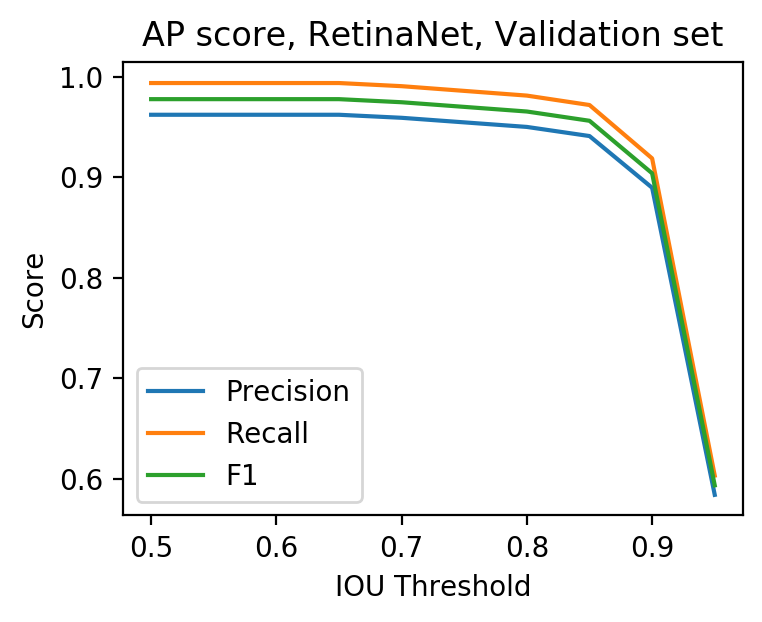

In [7]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(IOU_thres, precision_list)
plt.plot(IOU_thres, recall_list)
plt.plot(IOU_thres, f1_list)
plt.legend(['Precision', 'Recall', 'F1'])
plt.title('AP score, RetinaNet, Validation set')
plt.ylabel('Score')
plt.xlabel('IOU Threshold')


average_precision = np.average(precision_list)
average_recall = np.average(recall_list)
average_f1 = np.average(f1_list)

print('Avg. precision:', average_precision)
print('Avg. recall:   ', average_recall)
print('Avg. F1:       ', average_f1)